# Ising model problem solution

I will show 5 different implementations in increasing complexity and performance. Please ask me if you are interested in any of the tecniques, they apply quite broadly to the rest of the coding problems in this course. But "Solution 1" is sufficient.

First, i will show how to code up the problem, and do a number of iterations on a 50x50 grid at 20 temperatures. This number of iterations is set such that it takes about 10 seconds in total. In the end, I show how to do the plots.

We look at the case of h=0, and since everything is a function only of the product of beta and J, we just set J = 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

### Solution 1:
Copy grid, swap 1 element and choose whether to keep

In [2]:
default_settings = [np.linspace(2,2.5,20), (50,50), 0]

In [3]:
def init(shape):
    return np.random.choice([-1, 1], shape)

def calc_energy(state):
    nbor_magnetization = np.roll(state, 1, 0) + np.roll(state, 1, 1) + np.roll(state, -1, 0) + np.roll(state, -1, 1)
    return -np.sum(state * nbor_magnetization) / 2

def update(state, beta):
    for _ in range(state.size):
        rand_x, rand_y = np.random.randint(state.shape[0]), np.random.randint(state.shape[1])
        new_state = state.copy()
        new_state[rand_x, rand_y] *= -1
        dE = calc_energy(new_state) - calc_energy(state)
        
        if np.exp(-dE*beta) > np.random.rand():
            state[:] = new_state # only with the probability we keep the new state
            
def calc_stat(state):
    return np.abs(state.mean()), calc_energy(state)

def run_simulation(shape, beta, n_warmup, n_average):
    state = init(shape)
    stats = []
    for i in range(n_warmup + n_average):
        update(state, beta)
        if i >= n_warmup:
            stats.append(calc_stat(state))
    return stats

def run_multiple1(betas, shape, n_warmup, n_average):
    all_states = []
    for beta in betas:
        all_states.append(run_simulation(shape, beta, n_warmup, n_average))
    return np.array(all_states)

start_time = time.time()
iters = 2
run_multiple1(*default_settings, iters)
time_per_iter_1 = (time.time() - start_time)/iters
time_per_iter_1

6.248347997665405

### Solution 2: 
Here, we avoid the excessive copying of the states by just flipping the state back if rejected. Also, the calc_energy is slightly better. Lastly, we reuse already calculated energies

In [4]:
def init(shape):
    return np.random.choice([-1, 1], shape)

def calc_energy(state): ## UPDATED
    nbor_magnetization = np.roll(state, 1, 0) + np.roll(state, 1, 1)
    return -np.sum(state * nbor_magnetization)

def update(state, beta): ## UPDATED
    last_energy = calc_energy(state)
    for _ in range(state.size):
        rand_x, rand_y = np.random.randint(state.shape[0]), np.random.randint(state.shape[1])
        state[rand_x, rand_y] *= -1
        new_energy = calc_energy(state)
        dE = new_energy - last_energy
        
        if np.exp(-dE*beta) > np.random.rand():
            last_energy = new_energy # 
        else:
            state[rand_x, rand_y] *= -1 # flip back if rejected
            
def calc_stat(state):
    return np.abs(state.mean()), calc_energy(state)

def run_simulation(shape, beta, n_warmup, n_average):
    state = init(shape)
    stats = []
    for i in range(n_warmup + n_average):
        update(state, beta)
        if i >= n_warmup:
            stats.append(calc_stat(state))
    return stats

def run_multiple2(betas, shape, n_warmup, n_average):
    all_states = []
    for beta in betas:
        all_states.append(run_simulation(shape, beta, n_warmup, n_average))
    return np.array(all_states)

start_time = time.time()
iters = 5
run_multiple2(*default_settings, iters)
time_per_iter_2 = (time.time() - start_time)/iters
time_per_iter_2

2.2448050498962404

### Solution 3
Actually, we do not need to calculate the full energy, just the energy difference of the 4 bonds the fliped spin have
 
Comment: since we continually calculate energy differences we can track the energy and magnetisation difference by just adding any difference in each step, but due to the frequency of calculating the statistics (once for each N\*N loop iterations), this does not make it significantly faster.

In [5]:
def init(shape):
    return np.random.choice([-1, 1], shape)

def calc_energy(state):
    nbor_magnetization = np.roll(state, 1, 0) + np.roll(state, 1, 1)
    return -np.sum(state * nbor_magnetization)

def update(state, beta): ## UPDATED
    for _ in range(state.size):
        rand_x, rand_y = np.random.randint(state.shape[0]), np.random.randint(state.shape[1])
        nbor_mag = state[(rand_x-1) % state.shape[0], rand_y]\
                 + state[(rand_x+1) % state.shape[0], rand_y]\
                 + state[rand_x, (rand_y-1) % state.shape[1]]\
                 + state[rand_x, (rand_y+1) % state.shape[1]]
        dE = -2*(-nbor_mag)*state[rand_x, rand_y]
        if np.exp(-dE*beta) > np.random.rand():
            state[rand_x, rand_y] *= -1
            
def calc_stat(state):
    return np.abs(state.mean()), calc_energy(state)

def run_simulation(shape, beta, n_warmup, n_average):
    state = init(shape)
    stats = []
    for i in range(n_warmup + n_average):
        update(state, beta)
        if i >= n_warmup:
            stats.append(calc_stat(state))
    return stats

def run_multiple3(betas, shape, n_warmup, n_average):
    all_states = []
    for beta in betas:
        all_states.append(run_simulation(shape, beta, n_warmup, n_average))
    return np.array(all_states)

start_time = time.time()
iters = 20
run_multiple3(*default_settings, iters)
time_per_iter_3 = (time.time() - start_time)/iters
time_per_iter_3

0.5300957679748535

### Solution 4:
Now we get into the "more advanced" territory. Numba is able to take very simple code and speed it up by compiling it to c. 
comment: the "compiling" takes some time the first time a function is called. To get the propper time, we thus call it once before the timing

In [6]:
import numba

In [7]:
def init(shape):
    return np.random.choice([-1, 1], shape)

def calc_energy(state):
    nbor_magnetization = np.roll(state, 1, 0) + np.roll(state, 1, 1)
    return -np.sum(state * nbor_magnetization)

@numba.njit ## UPDATED njit added
def update(state, beta):
    for _ in range(state.size):
        rand_x, rand_y = np.random.randint(state.shape[0]), np.random.randint(state.shape[1])
        nbor_mag = state[(rand_x-1) % state.shape[0], rand_y]\
                 + state[(rand_x+1) % state.shape[0], rand_y]\
                 + state[rand_x, (rand_y-1) % state.shape[1]]\
                 + state[rand_x, (rand_y+1) % state.shape[1]]
        dE = -2*(-nbor_mag)*state[rand_x, rand_y]
        if np.exp(-dE*beta) > np.random.rand():
            state[rand_x, rand_y] *= -1

def calc_stat(state):
    return np.abs(state.mean()), calc_energy(state)

def run_simulation(shape, beta, n_warmup, n_average):
    state = init(shape)
    stats = []
    for i in range(n_warmup + n_average):
        update(state, beta)
        if i >= n_warmup:
            stats.append(calc_stat(state))
    return stats

def run_multiple4(betas, shape, n_warmup, n_average):
    all_states = []
    for beta in betas:
        all_states.append(run_simulation(shape, beta, n_warmup, n_average))
    return np.array(all_states)

run_multiple4(*default_settings, 1)
start_time = time.time()
iters = 4000
run_multiple4(*default_settings, iters)
time_per_iter_4 = (time.time() - start_time)/iters
time_per_iter_4

0.0024176159501075743

### Solution 5:
A normal computer has multiple cores (computing units), and numba is able to utilize these if we give it a loop where all iterations are independant and thus can run at the same time. This is not true for the loop in "update", but it is true for the loop in "run_simulation" (why?). 
One complexity is that numba does not support the axis argument of roll, so we have to write the loop ourselves

In [8]:
@numba.njit
def init(shape): ## UPDATED: choices need to be numpy array
    return np.random.choice(np.array([-1, 1]), shape)

@numba.njit
def calc_energy(state): ## UPDATED: numpy roll implemented here. Slightly faster due to removing intermediate arrays
    energy = 0.
    n, m = state.shape 
    for i in range(n):
        for j in range(m):
            energy -= state[i,j] * (state[(i +1)%n, j] + state[i, (j+1) % m])
    return energy

@numba.njit
def update(state, beta):
    for _ in range(state.size):
        rand_x, rand_y = np.random.randint(state.shape[0]), np.random.randint(state.shape[1])
        nbor_mag = state[(rand_x-1) % state.shape[0], rand_y]\
                 + state[(rand_x+1) % state.shape[0], rand_y]\
                 + state[rand_x, (rand_y-1) % state.shape[1]]\
                 + state[rand_x, (rand_y+1) % state.shape[1]]
        dE = -2*(-nbor_mag)*state[rand_x, rand_y]
        if np.exp(-dE*beta) > np.random.rand():
            state[rand_x, rand_y] *= -1

@numba.njit ## UPDATED: njit added
def calc_stat(state):
    return np.abs(state.mean()), calc_energy(state)

@numba.njit ## UPDATED: njit added
def run_simulation(shape, beta, n_warmup, n_average):
    state = init(shape)
    stats = []
    for i in range(n_warmup + n_average):
        update(state, beta)
        if i >= n_warmup:
            stats.append(calc_stat(state))
    return stats

@numba.njit(parallel=True)
def run_multiple5(betas, shape, n_warmup, n_average):
    all_states = [[(0., 0.)]] * len(betas)
    for i in numba.prange(len(betas)):
        all_states[i] = run_simulation(shape, betas[i], n_warmup, n_average)
    return np.array(all_states)

run_multiple5(*default_settings, 1)
start_time = time.time()
iters = 30000
run_multiple5(*default_settings, iters)
time_per_iter_5 = (time.time() - start_time)/iters
time_per_iter_5

0.0003650269985198975

### Solution 6:
Now it gets really advanced, and quite hard to compare performance. But this algorithm tries to flip whole regions of spins, which means that it has much shorter correlation time near the critical point. This means that much fewer updates are needed to bring systems to convergence.

In [9]:
@numba.njit
def init(shape):
    return np.random.choice(np.array([-1, 1]), shape)

@numba.njit
def calc_energy(state):
    energy = 0.
    n, m = state.shape 
    for i in range(n):
        for j in range(m):
            energy -= state[i,j] * (state[(i +1)%n, j] + state[i, (j+1) % m])
    return energy

# inspiration: https://github.com/Wizaron/Ising2D/blob/master/code/Ising2D/Wolff_algorithm/ising2dwolff.py
@numba.jit(nopython=True)
def wolff_step(state,Padd, stack):
    stack[:] = 0
    n, m = state.shape
    rand_x, rand_y = np.random.randint(n),np.random.randint(m)
    stack[0] = [rand_x, rand_y]
    stack_len=1
    
    oldspin=state[rand_x, rand_y]
    state[stack_len] *= -1
    tried_updates = 1
    while stack_len:
        stack_len -= 1
        current_x, current_y = stack[stack_len]
        for nbor_x, nbor_y in np.array([((current_x-1)%n, current_y), ((current_x+1)%n, current_y), (current_x, (current_y-1)%m), (current_x, (current_y+1)%m),]):
            if state[nbor_x, nbor_y] == oldspin: 
                tried_updates += 1
                if np.random.uniform(0, 1) < Padd :
                    state[nbor_x, nbor_y] = -oldspin
                    stack[stack_len] = [nbor_x, nbor_y]
                    stack_len += 1
    return tried_updates
                    
@numba.jit(nopython=True)
def update(state, beta, stack):
    Padd = 1-np.exp(-2*beta)
    tried_updates = 0
    while tried_updates < state.size:
        tried_updates += wolff_step(state, Padd, stack)

@numba.njit
def calc_stat(state):
    return np.abs(state.mean()), calc_energy(state)

@numba.njit
def run_simulation(shape, beta, n_warmup, n_average):
    state = init(shape)
    stack = np.zeros((state.size, 2), dtype=np.int32)
    stats = []
    for i in range(n_warmup + n_average):
        update(state, beta, stack)
        if i >= n_warmup:
            stats.append(calc_stat(state))
    return stats

@numba.njit(parallel=True)
def run_multiple6(betas, shape, n_warmup, n_average):
    all_states = [[(0., 0.)]] * len(betas)
    for i in numba.prange(len(betas)):
        all_states[i] = run_simulation(shape, betas[i], n_warmup, n_average)
    return np.array(all_states)

run_multiple6(*default_settings, 1)
start_time = time.time()
iters = 300
run_multiple6(*default_settings, iters)
time_per_iter_6 = (time.time() - start_time)/iters
time_per_iter_6

0.03189687887827555

# Solutions summary:
For the 5 matropolis hastings algorithms, these are the timings per iteration:

Text(0.5, 1.0, 'Performance of solutions')

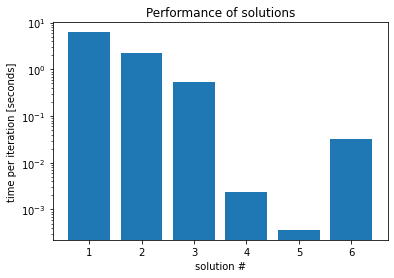

In [10]:
plt.bar(np.arange(1,7), [time_per_iter_1, time_per_iter_2, time_per_iter_3, time_per_iter_4, time_per_iter_5, time_per_iter_6])
plt.yscale("log")
plt.xlabel("solution #")
plt.ylabel("time per iteration [seconds]")
plt.title("Performance of solutions")

# Results and phase transition

First, we plot the energy after each iteration so we can see how long time it takes to converge:

<Figure size 432x288 with 0 Axes>

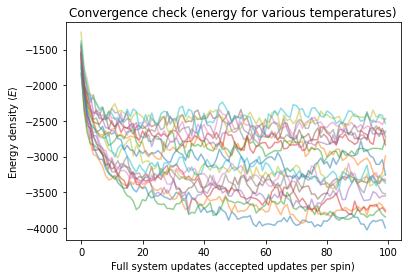

<Figure size 432x288 with 0 Axes>

In [12]:
betas = np.linspace(2,2.7, 20)
shape = (50,50)

all_states = run_multiple5(1/betas, shape, n_warmup=0, n_average=100)
plt.plot(all_states[:,:,1].T, alpha = 0.5);
plt.title("Convergence check (energy for various temperatures)")
plt.ylabel(r"Energy density $\langle E \rangle$")
plt.xlabel("Full system updates (accepted updates per spin)")
plt.figure()

This plot indicates that it takes about ~20 iterations before all temperatures are visibly converged. Thus running for 100 iterations warmup will definetely allow the system to thermalize sufficiently. Then we run another (however many we have patience for) iterations, and plot a the distribution of magnetization for each temperature.

Text(0.5, 0, 'Temperature ($k_b T/J$)')

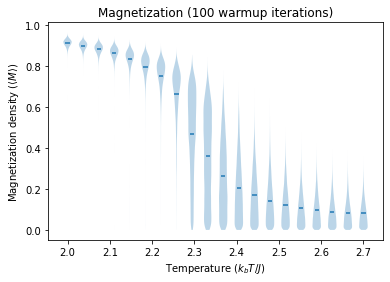

In [14]:
all_states = run_multiple5(1/betas, shape, n_warmup=100, n_average=100000)
plt.violinplot(all_states[:,:,0].T, betas, widths=0.02, showextrema=False, showmeans=True);
plt.title("Magnetization (100 warmup iterations)")
plt.ylabel(r"Magnetization density ($\langle M \rangle$)")
plt.xlabel(r"Temperature ($k_b T/J$)")